In [40]:
import os
import bigfish as bf
import bigfish.plot as plot
import bigfish.segmentation as segmentation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import cv2
from pylab import *
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from sklearn.mixture import GaussianMixture

Reading in data using big-fish and splitting DAPI channel (nuc) and FISH channels (cy3 and cy5)

In [54]:
path = '/Volumes/MATH_BACKUP/Vaeth/mila_CLN7_NET1_03_R3D_D3D.dv'
img = bf.stack.read_dv(path)
nuc = img[0,...]
cy3 = img[1,...]
cy5 = img[2,...]

using max projection to collapse nucleus z stacks into a 2D image.  

In [55]:
nuc_max = bf.stack.maximum_projection(nuc)
nuc_max = bf.stack.rescale(nuc_max, channel_to_stretch=0)
# bf.plot.plot_images(nuc_max)


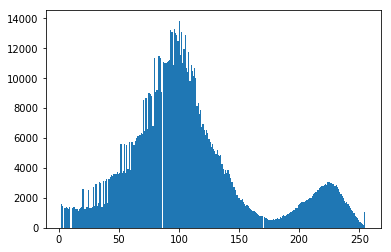

In [56]:
# Converting image to 255 (8 bit integers)
img = cv2.normalize(nuc_max, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

#log normalization  
log_img = (np.log(img+1)/(np.log(1+np.max(img))))*255
norm_image = log_img.astype(np.uint8)

# flatten matrix into an array
data = norm_image.ravel()


# get rid of background dark pixels (helps smooth gaussian)
data = data[data != 0]
data = data[data != 1]

# plot a histogram of pixel intensities
ax = plt.hist(data, bins = 256)
plt.show()

In the histogram above we can easily see a bimodal distribution.  The large peak on the left represents background pixels while the smaller peak on the right represents pixels within nuclei.  In order to automate threshold detection we need to make a mathematical representation of this data by curve fitting and find the local minimum between these two curves.  

sci-kit learn has a Gaussian Mixture model that should do the trick.

/Users/tylermatheny/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


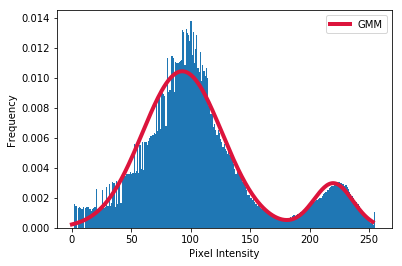

In [57]:
gmm = GaussianMixture(n_components = 2)
gmm = gmm.fit(X=np.expand_dims(data,1))

# Evaluate GMM
gmm_x = np.linspace(0,253,256)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))


# Plot histograms and gaussian curves
fig, ax = plt.subplots()
ax.hist(norm_image.ravel(),255,[2,256], normed=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")

plt.legend()

plt.show()

The gaussian mixture approximates our data pretty well.  Now we need to fing the local minimum between the two curves.  This point will serve as our threshold for filtering.  It is important to have this threshold generated by this curve fitting method, because this threshold can varry significantly from image to image and setting a global threshold for all images will result in incorrect detection of nuclei

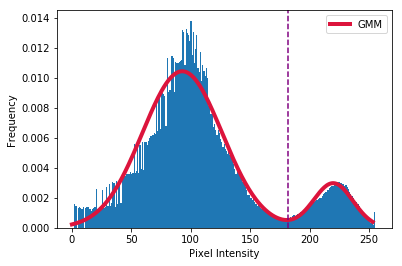

In [58]:
# finding threshold value by finding local min between curves
thresh_= argrelextrema(gmm_y, np.less)
thresh_ = int(thresh_[0][0])

#plotting data and gaussian model
fig, ax = plt.subplots()
ax.hist(norm_image.ravel(),255,[2,256], normed=True)
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

# plotting thresh value
ax.axvline(x=thresh_, color = 'purple',linestyle='--')

ax.set_ylabel("Frequency")
ax.set_xlabel("Pixel Intensity")

plt.legend()

plt.show()

We can see above that our autothresholding method does a good job at diving the two curves. Now we will use this threshold as the starting point for segmenting nuclei using bigfish

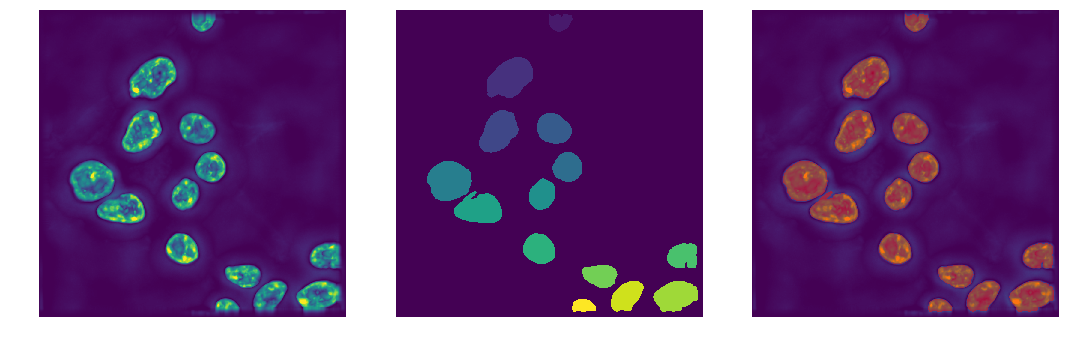

In [59]:
nuc_mask = bf.segmentation.thresholding(norm_image, threshold= thresh_)
nuc_mask = bf.segmentation.clean_segmentation(nuc_mask, small_object_size= 2000, fill_holes=True)
nuc_label = bf.segmentation.label_instances(nuc_mask)
kernel = np.ones((10, 10), 'uint8')
images = [nuc_max, nuc_mask, nuc_label]
titles = ['max_proj', 'masked nuclei', 'labeled nuclei']
bf.plot.plot_segmentation(nuc_max, np.uint8(nuc_label))

We can see above that this method does a resonble job at labeling nuclei.  But in some cases, the nuclei are close together.  This can cause problems where two nuclei get labeled as one.  Therefore we can add an erode function to ensure we get distinct nuclei

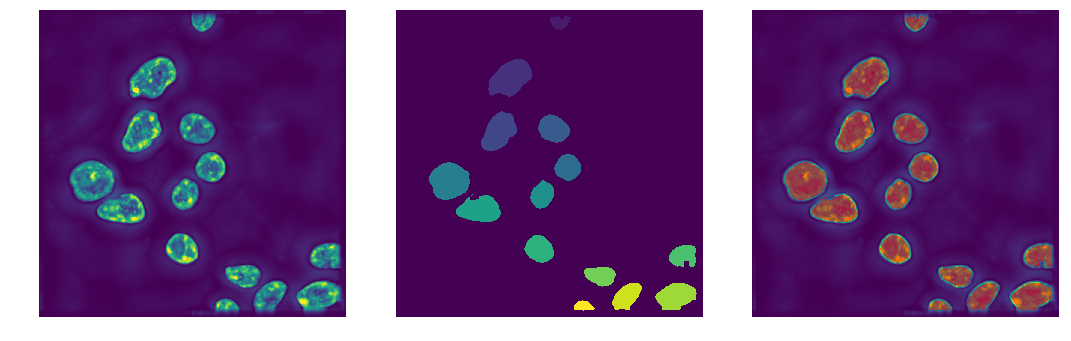

In [60]:
nuc_label = cv2.erode(np.uint8(nuc_label), kernel, iterations=1)
images = [nuc_max, nuc_mask, nuc_label]
titles = ['max_proj', 'masked nuclei', 'labeled nuclei']
bf.plot.plot_segmentation(nuc_max, np.uint8(nuc_label))